# Symmetry Reduced VQE

The first step is to find the blocks of a Hamiltonian which has have been reduced due to the application of some symmerty consideration.  Each block will then have an associated wavefunction,
$$ |\psi^b> = U(\phi^b_1,\phi^b_1,\ldots)|000\ldots> $$
where $|000\ldots>$ is the state in which $Q$ qubits are in their ground state with $Q$ deterimed by the size of the block $N$ as $Q = \log_2 N$ rounded up and $U$ is a linear transformation with some set of parameters $\{\phi^b_i\}$ which depend on the block.  

For this notebook we will use the linear transformation Anzatz from here: https://arxiv.org/abs/1907.01493.  It gives $U$ as applying y-rotations to each qubit, then coupling each qubit pair with a C-not gate and repreating. 
$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$
where the $\pm$ in the subscripts of the C-not gates alternates (see below for an exact definition).

The Hamiltonian might be block diagonal or it might have some nonzero off diagonal blocks.  In the most general case, the minimization function invovles wave functions from different blocks.  

$$ E = \sum_{a,b}<\psi^a|H_{ab}|\psi^b> $$

To minimize this function we will use the simultaneous perturbation stochastic approximation algorithm.

In [333]:
#Only needed if running on the quantum device
from qiskit import IBMQ,transpile
from qiskit.tools.monitor import job_monitor
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-afrl', group='air-force-lab', project='quantum-sim')
backend = provider.get_backend('ibmq_jakarta')
#backend = provider.get_backend('ibmq_lima')

ibmqfactory.load_account:WARNING:2022-03-07 09:58:00,245: Credentials are already in use. The existing account in the session will be replaced.


## Hamiltonian

As an example for this notebook we will use the Hamiltonian generated from Example_Matrix_Creation_Sign_Fix.ipynb

I do not know how to export the summed operator from OpFlow so I will import the numpy matrix and then re-extract the Pauli terms here.

In [408]:
import numpy as np 

#H = np.load('Hamiltonian_Example.npy')
# I have -2.0 < u 2.0 in steps of 0.1

u=0.4
t=-1.0
H = np.load('H_mu_'+str(u)+"_t_"+str(t)+'.npy')

In [448]:
e,y = np.linalg.eig(H)

np.sort(e)

array([-3.71552471e+00, -3.70650070e+00, -3.51702088e+00, -3.50600195e+00,
       -1.80997512e+00, -1.80997512e+00, -1.60000000e+00, -1.60000000e+00,
       -1.60000000e+00, -1.60000000e+00, -1.40997512e+00, -1.40997512e+00,
        6.12544874e-16,  2.00498750e-01,  2.01496176e-01,  4.00000000e-01,
        4.00000000e-01,  4.00000000e-01,  4.00000000e-01,  4.00000000e-01,
        4.00000000e-01,  5.98503824e-01,  5.99501250e-01,  8.00000000e-01,
        2.20997512e+00,  2.20997512e+00,  2.40000000e+00,  2.40000000e+00,
        2.40000000e+00,  2.40000000e+00,  2.60997512e+00,  2.60997512e+00,
        4.30600195e+00,  4.31702088e+00,  4.50650070e+00,  4.51552471e+00])

Now that the Hamiltonian has been imported let us break it into blocks and exctract the Pauli coordinates.  

In [410]:
from qiskit.opflow import (I, X, Y, Z)
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit import quantum_info as qi

# Function to add elements to a block so that it fits onto qubits
def complete_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        vnew[i] = 10
        b11.append(vnew)
    return b11

def complete_off_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        b11.append(vnew)
    return b11



In [411]:
import math
N = 4
S = 2
bL = math.comb(4,2)

blocks = {}
for bi in range(bL):
    for bj in range(bi,bL):
        bij = [[H[i + bL*bi][j + bL*bj] for j in range(0,bL)] for i in range(0,bL)]
        if np.amax(np.abs(bij)) > 10**(-5):
            if bi == bj:
                bij = complete_diagonal(bij)
            else:
                bij = complete_off_diagonal(bij)
            bij_pauli = MatrixOp(bij).to_pauli_op()
            blocks[str(bi) + ',' + str(bj)] = bij_pauli
        

The object *blocks* is a dictionary of *SumedOp* lists of *PauliOp* objects.  

In [412]:
import pandas as pd

pd.DataFrame(blocks['3,3'].to_matrix())

,0,1,2,3,4,5,6,7
0,0.4+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
1,-1.0+0.0j,0.4+0.0j,-1.0+0.0j,-1.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j
2,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
3,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.8+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
4,1.0+0.0j,0.0+0.0j,-1.0+0.0j,-1.0+0.0j,0.4+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j
5,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.4+0.0j,0.0+0.0j,0.0+0.0j
6,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,10.0+0.0j,0.0+0.0j
7,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,10.0+0.0j


In [413]:
print(blocks['0,0'])

SummedOp([
  2.8000000000000003 * III,
  -0.5 * IIX,
  0.10000000000000002 * IIZ,
  -0.25 * IXI,
  -0.25 * IXX,
  0.25 * IXZ,
  -0.25 * IYY,
  -2.4 * IZI,
  -0.5 * IZX,
  0.10000000000000002 * IZZ,
  0.5 * XII,
  -0.25 * XXI,
  -0.25 * XXX,
  -0.25 * XXZ,
  0.25 * XYY,
  0.5 * XZI,
  -0.25 * YXY,
  -0.25 * YYI,
  -0.25 * YYX,
  -0.25 * YYZ,
  -2.3 * ZII,
  -0.25 * ZXI,
  -0.25 * ZXX,
  0.25 * ZXZ,
  -0.25 * ZYY,
  2.5 * ZZI
])


Let's take a sanity check here and make sure we can rebuild a Hamiltonian with these completed blocks and that the ground state is still the same.

In [414]:
keys = list(blocks.keys())

size = int(2**np.ceil(np.log2(bL)))
H_complete = np.array([[0 for i in range(size*bL)] for j in range(size*bL)])

for bi in range(bL):
    for bj in range(bi,bL):
        key = str(bi) + ',' + str(bj)
        if key  in keys:
            block = blocks[key].to_matrix()
        else:
            block = np.array([[0.0 for i in range(size)] for j in range(size)])
        for i in range(size):
            for j in range(size):
                H_complete[i + bi*size, j + bj*size] = block[i,j]
                H_complete[i + bj*size, j + bi*size] = block[j,i]
                

<ipython-input-414-4f4400865c4e>:15: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bi*size, j + bj*size] = block[i,j]
<ipython-input-414-4f4400865c4e>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bj*size, j + bi*size] = block[j,i]


In [415]:
pd.set_option("display.max_rows", 15, "display.max_columns", 15)
pd.DataFrame(H_complete)

,0,1,2,3,4,5,6,...,41,42,43,44,45,46,47
0,0,-1,0,0,1,0,0,...,0,0,0,0,0,0,0
1,-1,0,-1,-1,0,1,0,...,0,0,0,0,0,0,0
2,0,-1,0,0,-1,0,0,...,0,0,0,0,0,0,0
3,0,-1,0,0,-1,0,0,...,0,0,0,0,0,0,0
4,1,0,-1,-1,0,-1,0,...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,0,0,0,0,0,0,0,...,-1,0,0,-1,0,0,0
44,0,0,0,0,0,0,0,...,0,-1,-1,0,-1,0,0
45,0,0,0,0,0,0,0,...,1,0,0,-1,0,0,0
46,0,0,0,0,0,0,0,...,0,0,0,0,0,10,0


In [416]:
e_comp,y_comp = np.linalg.eig(H_complete)

print(np.sort(e_comp)[0])
print(np.sort(e)[0])

(-4.0000000000000036+0j)
-3.715524708330676


## The Anzatz circuit

The Ansatz will be a collection of controlled-Ry gates so that the entire circuit can be turned on or off based on the state of one auxiliary qubit.  This way we can measure off diagonal blocks.  Say $U_1$ generates the state for block 1 and $U_2$ generates the state for block 2.  By putting the auxiliary qubit in a superposition we can apply the operator $(1+U_2^{\dagger}U_1)/\sqrt{2}$.  So we have,
$$ p_{00...} = \frac{1}{4}<00...|1+U_1^{\dagger}U_2|00...><00...|1+U_2^{\dagger}U_1|00...> = \frac{1}{4}|1+<\psi_2|\psi_1>|^2$$
So we have,
$$<\psi_2|\psi_1> = \pm 2\sqrt{p_{00...}}-1 =2\sqrt{p_{00...}}-1$$
where in the last equality we used that $|<\psi_2|\psi_1>| \leq 1$.

Unlike in other versions I do not allow for multiple applications of the ansatz.  i.e. I restrict $T =1$.  This can be changed but speciall attention needs to be payed to the off-diagonal part.

In [417]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute


# the number of qubits is given by the size of the blocks
# note: the size of the blocks has already been adjusted to fit the qubits
Q = int(np.log2(len(blocks['0,0'].to_matrix())))

qbs = [1,3,5,6]
Qj = 7

In [418]:
from qiskit.circuit.library.standard_gates import RYGate

#to check that I am defing CRy correctly
def cry(phi):
    return RYGate(phi).control(1)

#CRy in terms of Rzx gates
def apply_CRy(phi,cir,q1,q2,meta = False):
    if meta:
        cir.append(cry(phi),(q1,q2))
    else:
        cir.rz(-np.pi/2,q2)
        cir.rzx(-phi/2,q1,q2)
        cir.rz(np.pi/2,q2)
        cir.ry(phi/2,q2)
    return cir

qr = QuantumRegister(2)
qc1 = QuantumCircuit(qr)
qc2 = QuantumCircuit(qr)

qc1.h(0)
qc1 = apply_CRy(0.4,qc1,0,1)

qc2.h(0)
#qc2.append(cry(0.4), [0,1])
qc1 = apply_CRy(0.4,qc2,0,1,meta = True)

psi1 = qi.Statevector.from_instruction(qc1)
psi2 = qi.Statevector.from_instruction(qc2)
np.amax(np.abs(psi2-psi1))

0.0

In [419]:
def U(cir_i,phi_i,meta = False):  
    if meta:
        qbits = [0,1,2,3]
    else:
        qbits = qbs
    cir_i.x(qbits[0])
    cir_i = apply_CRy(phi_i[0],cir_i,qbits[0],qbits[1],meta)
    for q in range(1,Q):
        cir_i = apply_CRy(phi_i[2*q-1],cir_i,qbits[q],qbits[q+1],meta)
        cir_i = apply_CRy(phi_i[2*q],cir_i,qbits[q+1],qbits[q],meta)
    cir_i.x(qbits[0])
    return cir_i


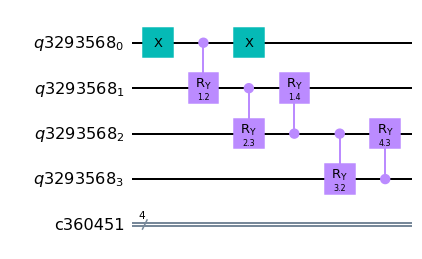

In [420]:
qr = QuantumRegister(Qj)
cr = ClassicalRegister(Qj)
cir_i = QuantumCircuit(qr , cr)
tst = U(cir_i,[1.2,2.3,1.4,3.2,4.3])

qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
tst_meta = U(cir_i,[1.2,2.3,1.4,3.2,4.3],meta = True)

tst_meta.draw(output = 'mpl')
#tst.draw(output = 'mpl')

In [421]:
psi1 = qi.Statevector.from_instruction(tst)
#psi1

Now we will do the off diagonal blocks.  

In [422]:

def U_off(cir_i,phi_a,p_label, phi_b,meta = False): 
    if meta:
        qbits = [0,1,2,3]
    else:
        qbits = qbs
    #Run Ua
    cir_i.h(qbits[0])
    cir_i = apply_CRy(phi_a[0],cir_i,qbits[0],qbits[1],meta)
    for q in range(1,Q):
        cir_i = apply_CRy(phi_a[2*q-1],cir_i,qbits[q],qbits[q+1],meta)
        cir_i = apply_CRy(phi_a[2*q],cir_i,qbits[q+1],qbits[q],meta)
    cir_i.h(qbits[0])
    #Insert Pauli
    for q in range(1,Q+1):
        if p_label[Q-q] == 'X':
            cir_i.x(qbits[q])
        if p_label[Q-q] == 'Y':
            cir_i.y(qbits[q])
        if p_label[Q-q] == 'Z':
            cir_i.z(qbits[q])
    #Run Ua^dagger = Ua^transpose
    cir_i.h(qbits[0])
    for q in range(1,Q):
        Lphi = len(phi_b)
        cir_i = apply_CRy(-phi_b[Lphi-2*q+1],cir_i,qbits[Q-q+1],qbits[Q-q],meta)
        cir_i = apply_CRy(-phi_b[Lphi-2*q],cir_i,qbits[Q-q],qbits[Q-q+1],meta)
    cir_i = apply_CRy(-phi_b[0],cir_i,qbits[0],qbits[1],meta)
    cir_i.h(qbits[0])
    
    
    return cir_i

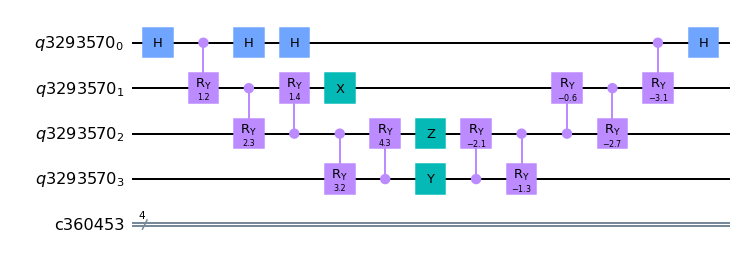

In [423]:
qr = QuantumRegister(Qj)
cr = ClassicalRegister(Qj)
cir_i = QuantumCircuit(qr , cr)
#tst = Ui_off(cir_i,[1.2,2.3,1.4,3.2,4.3],[1.2,2.3,1.4,3.2,4.3]) This should be identity 
tst = U_off(cir_i,[1.2,2.3,1.4,3.2,4.3],'YZX',[3.1,2.7,0.6,1.3,2.1])

qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
#tst = Ui_off(cir_i,[1.2,2.3,1.4,3.2,4.3],[1.2,2.3,1.4,3.2,4.3]) This should be identity 
tst_meta = U_off(cir_i,[1.2,2.3,1.4,3.2,4.3],'YZX',[3.1,2.7,0.6,1.3,2.1],meta=True)

#tst.draw(output = 'mpl')
tst_meta.draw(output = 'mpl')

In [424]:
psi1 = qi.Statevector.from_instruction(tst)
#psi1

In [425]:
(1+0.183966)/2

0.591983

# Calculating E

$$ E = \sum_{ab}<\psi^a|H_{ab}|\psi^b> = \sum_{ab}<000\ldots|U^{\dagger}(\{\phi^a\})H_{ab}U(\{\phi^b\})|000\ldots>$$

each $H_{ab}$ can be brocken down into its Puali components so that $H_{ab} = \sum_p c_p P_{ab,p}$.  Then we have

$$ E = \sum_{ab}\sum_p c_p <000\ldots|U^{\dagger}(\{\phi^a\})  P_{ab,p}U(\{\phi^b\})|000\ldots>$$.

We cannot measure $<\psi^a|P_{ab,p}|\psi^b>$ directly.  Instead we measure $|<\psi^a|P_{ab,p}|\psi^b>|^2$ which tells us nothing about the sign.  


To fix the issue we need to find a way to use the counts to recreate the desired measurement.  This can be done by looking at the counts in each occupation state. 

First we need to go through the circuit and add a $R_y(-\pi/2)$ gate on each qubit where $P_{ab,p}$ applies an X and an $R_x(\pi/2)$ gate to each qubit where $P_{ab,p}$ applies an Y.  This rotates all of the Pauli terms to Z.   Then we can take the count for each occupation state mulitply that count by $(-1)^n$ where n is the number of up qubits with a Puali term in $P_{ab,p}$. 

for example:

\begin{equation}
\begin{split}
<\psi|XZ|\psi> &= <(R_y(\pi/2)\otimes I)\psi|R^{\dagger}_y(\pi/2)XR_y(\pi/2)\otimes Z|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = <(R_y(\pi/2)\otimes I)\psi|ZZ|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = |<00|R^{\dagger}_y(\pi/2)\psi>|^2 + (-1)^1|<10|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^1|<01|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^2|<11|R^{\dagger}_y(\pi/2) \psi>|^2
\end{split}
\end{equation}

This unfortunetly does not work for $|\psi^a> \neq |\psi_b>$



### Stratagy

In order to run on the quantum device, I would like to group together all of the runs so that each time I measure energy, I only have to que once.  

1) We prepare the circuit to be measured for a given p_label and include measurment instructions.
    
    -> add an entry to the measurement instructions to tell if the block is off or on diagonal 
    
    -> if off diagonal the context of the measurment is changed.  meas = [['on'],[a,b,c]] or [['off']]

2) We collect all of the p_labels from a block into a circuit array

3) We collect all of the blocks into a circuit array

4) we send to the backend

5) we use the measurment instructions to decode the results
    
    ->if on diagonal use [a,b,c] to determine the sign of each entry
    
    ->if off-diagonal use $2\sqrt{p_{00...}}-1$

6) sum everything together to get the energy

### Prepare the circuits

This is where I left off.

In [426]:
import random

alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#Create an arbitrary collection of rotation angles
phi = []
for b in range(bL):
    phi_b = []
    for q in range(2*Q-1):
        rand = random.random()
        phi_b.append(rand)
    phi.append(phi_b)

XII
[1, 0, 0, 0]


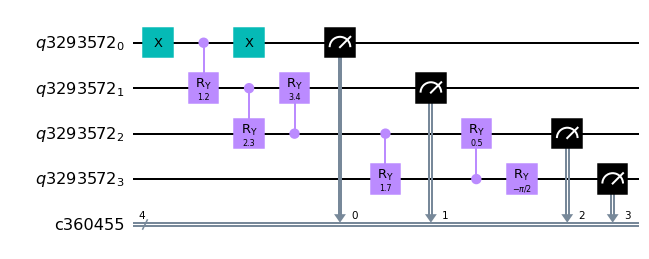

In [427]:
from qiskit import Aer
from qiskit.visualization import *
from qiskit import quantum_info as qi

def convert_to_circ(p_label,psi0,meta=False):
    if meta:
        qbits = [0,1,2,3]
    else:
        qbits = qbs
    #apply rotations
    psi = copy.deepcopy(psi0)
    pauli_qs = []
    Z_label = ''
    Q = len(p_label)
    for q,p in enumerate(p_label):
        if p == 'X':
            psi.ry(-np.pi/2,qbits[Q-q])
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Y':
            psi.rx(np.pi/2,qbits[Q-q])
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Z':
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'I':
            pauli_qs.append(0)
            Z_label += 'I'
    pauli_qs.append(0)
    #apply measurment 
    psi.measure(psi.qubits,psi.clbits)
    #return circut and measurement instructions
    return [psi,pauli_qs]


#Run a test
import copy
qr = QuantumRegister(Qj)
cr = ClassicalRegister(Qj)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,[1.2,2.3,3.4,1.7,0.5])

qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir = QuantumCircuit(qr , cr)
psi0_meta = U(cir,[1.2,2.3,3.4,1.7,0.5],meta=True)

p_label = blocks['0,0'][10].primitive.to_label()
cir_tst, lab_tst =  convert_to_circ(p_label,psi0) 
cir_tst_meta, lab_tst_meta =  convert_to_circ(p_label,psi0_meta,meta=True) 
print(p_label)
print(lab_tst)
#cir_tst.draw(output = "mpl")
cir_tst_meta.draw(output = "mpl")

### Collect the circuits

0.5
['on', [1, 0, 0, 0]]
XII


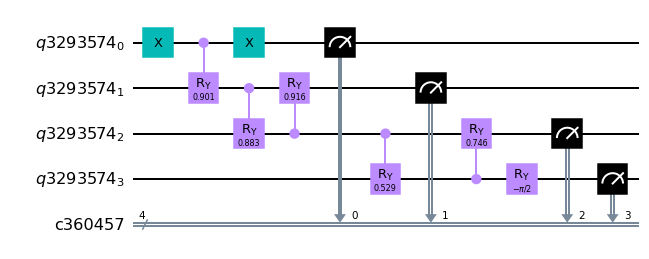

In [428]:
#This collects the circuits for the on-diagonal blocks only
def collect_diag_circs(phi_b,block,meta = False):
    if meta:
        qr = QuantumRegister(Q+1)
        cr = ClassicalRegister(Q+1)
    else:
        qr = QuantumRegister(Qj)
        cr = ClassicalRegister(Qj)
    cir = QuantumCircuit(qr , cr)
    psi0 = U(cir,phi_b,meta)
    cirs = []
    meas = []
    coef = []
    pauli = []
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        if np.abs(w) > 0:
            p_label = p.primitive.to_label()
            cir_p,meas_p  = convert_to_circ(p_label,psi,meta)
            cirs.append(cir_p)
            meas.append(['on',meas_p])
            coef.append(w)
            pauli.append(p_label)
    return cirs,meas,coef,pauli

block = blocks['0,0']
phi_b = phi[0]

circs, meas, coefs, pauli = collect_diag_circs(phi_b,block)
circs_m, meas_m, coefs_m, pauli_m = collect_diag_circs(phi_b,block,meta=True)

n=10
print(coefs[n])
print(meas[n])
print(pauli[n])
#circs[n].draw(output = "mpl")
circs_m[n].draw(output = "mpl")

-0.25
['off']
IZI


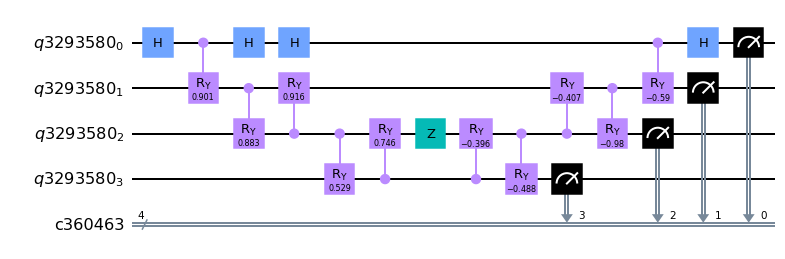

In [429]:
# This collects circuits for both on and off diagonal blocks but is unefficient for on-diagonal blocks
def collect_off_circs(phi_a,phi_b,block,meta = False):
    cirs = []
    meas = []
    coef = []
    pauli = []
    for p in block:
        p_label = p.primitive.to_label()
        if meta:
            qr = QuantumRegister(Q+1)
            cr = ClassicalRegister(Q+1)
        else:
            qr = QuantumRegister(Qj)
            cr = ClassicalRegister(Qj)
        cir = QuantumCircuit(qr , cr)
        psi0 = U_off(cir,phi_a,p_label,phi_b,meta)
        psi = copy.deepcopy(psi0)
        psi.measure(psi.qubits,psi.clbits)
        w = p.coeff
        if np.abs(w) > 0.0:
            cirs.append(psi)
            meas.append(['off'])
            coef.append(w)
            pauli.append(p_label)
    return cirs,meas,coef,pauli


block = blocks['0,1']
phi_a = phi[0]
phi_b = phi[1]

circs, meas, coefs, pauli = collect_off_circs(phi_a,phi_b,block)
circs_m, meas_m, coefs_m, pauli_m = collect_off_circs(phi_a,phi_b,block,meta=True)

n=1
print(coefs[n])
print(meas[n])
print(pauli[n])
#circs[n].draw(output = "mpl")
circs_m[n].draw(output = "mpl")

192
0.08333333333333336
['on', [1, 0, 0, 0]]
['0,0', 'XII']


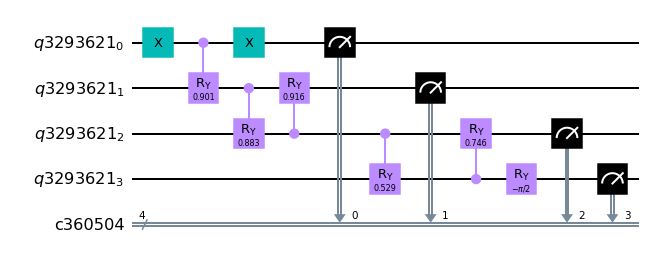

In [430]:
# collect all the circuits 
# The off diagonal coefs are doubled to take care of the Hermition conjugate
def collect_circs(alpha,phi,blocks,meta=False):
    circs = []
    meas = []
    coefs = []
    paulis = []
    for key in list(blocks.keys()):
        if key[0] == key[2]:
            circ_b, meas_b, coef_b, pauli_b = collect_diag_circs(phi[int(key[0])],blocks[key],meta)
            for b in range(len(coef_b)):
                circs.append(circ_b[b])
                meas.append(meas_b[b])
                coefs.append(alpha[int(key[0])]*alpha[int(key[2])]*coef_b[b])
                paulis.append([key,pauli_b[b]])
        else:
            circ_b, meas_b, coef_b, pauli_b = collect_off_circs(phi[int(key[0])],phi[int(key[2])],blocks[key],meta)
            for b in range(len(coef_b)):
                circs.append(circ_b[b])
                meas.append(meas_b[b])
                coefs.append(alpha[int(key[0])]*alpha[int(key[2])]*coef_b[b])
                paulis.append([key,pauli_b[b]])
    return circs, meas, coefs, paulis

circs, meas, coefs, paulis = collect_circs(alpha,phi,blocks)
circs_m, meas_m, coefs_m, paulis_m = collect_circs(alpha,phi,blocks,meta=True)

n=10
print(len(circs))
print(coefs[n])
print(meas[n])
print(paulis[n])
#circs[n].draw(output = "mpl")
circs_m[n].draw(output = "mpl")

### Run function

In [431]:
from qiskit.transpiler.passes.calibration import RZXCalibrationBuilder
from qiskit.transpiler import PassManager

def Rzx_Pass(circ):
    native_gates = ['rz', 'sx', 'rzx', 'x','cx']
    pass_ = RZXCalibrationBuilder(backend)
    circ_pile = transpile(circ, backend, basis_gates=native_gates)
    circ_scaled = PassManager(pass_).run(circ_pile)
    return circ_scaled

def Rzx_Pass_All(circs):
    out = []
    for circ in circs:
        out_i = Rzx_Pass(circ)
        out.append(out_i)
    return out
    
circs_pass = Rzx_Pass_All(circs)

['0,0', 'XXX']


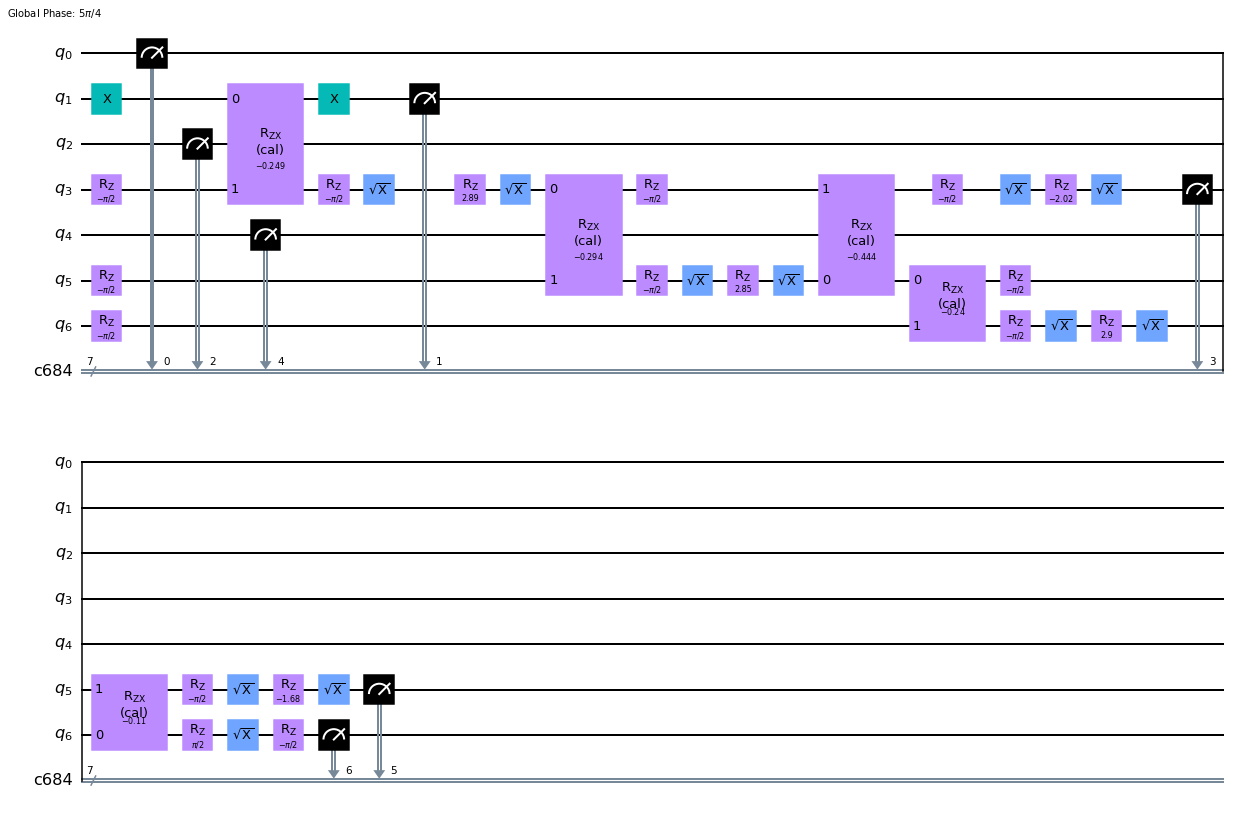

In [432]:
n=12
print(paulis[n])
circ_pass[n].draw(output = 'mpl')

In [433]:
circs, meas, coefs, pualis = collect_circs(alpha,phi,blocks)

def get_results(circs, method = 'matrix',save_id_file = None):
    if method == 'matrix':
        # add results
        r = []
        for l in range(len(circs)):
            circs[l].remove_final_measurements()
            wave = qi.Statevector.from_instruction(circs[l])
            r_l = wave.probabilities_dict()
            r.append(r_l)
    
    if method == "simulator":
        sim = Aer.get_backend("qasm_simulator")
        r = execute(circs, backend = sim).result().get_counts()
        
    if method == "quantum":
        job = backend.run(transpile(circs, backend), meas_level=2, shots=8192)
        job_id = job.job_id()
        print(job_id)
        np.save(save_id_file,[job_id])
        r = job.result().get_counts()
        
    if method == "quantum_scaled":
        circs_pass = Rzx_Pass_All(circs)
        job = backend.run(transpile(circs_pass, backend), meas_level=2, shots=8192)
        job_id = job.job_id()
        print(job_id)
        np.save(save_id_file,[job_id])
        r = job.result().get_counts()
        
        
    return r

r_m = get_results(circs_m, method = 'matrix')
r = get_results(circs, method = 'matrix')
r_pass = get_results(circs_pass, method = 'matrix')
#r = get_results(circs, method = 'simulator')
#r = get_results(circs, method = 'quantum')

### Analyze results

In [434]:
def energy_from_results(r,meas,coefs,meta=False):
    if meta:
        qbits = [0,1,2,3]
    else:
        qbits = qbs
    E = 0
    QL=len(list(r[0].keys())[0])
    key000 = "".join(['0' for i in range(QL)])
    for l in range(len(r)):
        if meas[l][0] == 'on': 
            z_measure = 0
            total = 0
            for key in list(r[l].keys()):
                n = 0
                for q in range(Q+1):
                    if key[QL-1-qbits[q]] == '1' and meas[l][1][Q-q] == 1:
                        n += 1
                z_measure += (-1)**n * r[l][key] 
                total += r[l][key]
            E += coefs[l]*z_measure/total
        elif meas[l][0] == 'off':
            total = np.sum([r[l][key] for key in list(r[l].keys())])
            p0 = r[l][key000]/total
            E += 2*coefs[l]*( 2*np.sqrt(p0) - 1 )
    return np.real(E)

em = energy_from_results(r_m,meas,coefs,meta=True)
e = energy_from_results(r,meas,coefs)
e_pass = energy_from_results(r_pass,meas,coefs)

print(em)
print(e)
print(e_pass)

-1.4690088953905
-1.4690088953904987
-1.4690088953904992


In [435]:
#Check against H_complete               
wave_full = []
for b in range(bL):
    qr = QuantumRegister(Q+1)
    cr = ClassicalRegister(Q+1)
    cir = QuantumCircuit(qr , cr)
    psi_b = U(cir,phi[b],meta=True)
    wave_b = alpha[b]*qi.Statevector.from_instruction(psi_b).data
    wave_full.append(wave_b)
wave_full = np.array(wave_full).flatten()

IxH = np.kron(H_complete,[[1,0],[0,1]])
np.dot(np.conjugate(wave_full),np.dot(IxH,wave_full))


(-1.8609255296637672+0j)

In [436]:
#Check Simulator
circs, meas, coefs, pualis = collect_circs(alpha,phi,blocks)
circs_pass = Rzx_Pass_All(circs)
r = get_results(circs_pass, method = 'simulator')
energy_from_results(r,meas,coefs)

-1.4677400338018356

In [437]:
#Check Quantum Scaled
#save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/job_check"
#circs, meas, coefs, pualis = collect_circs(alpha,phi,blocks)
#r = get_results(circs_pass, method = 'quantum_scaled', save_id_file = save_id_file)
#energy_from_results(r,meas,coefs)

In [438]:
#Check Quantum
#save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/job_check"
#circs, meas, coefs, pualis = collect_circs(alpha,phi,blocks)
#r = get_results(circs, method = 'quantum', save_id_file = save_id_file)
#energy_from_results(r,meas,coefs)

In [439]:
#function to test each block
#Used for debugging not for running the algorithm
def E_block(b_label):
    h00 = blocks[b_label].to_matrix()
    Ixh00 = np.kron(h00,[[1,0],[0,1]])

    qr = QuantumRegister(Q+1)
    cr = ClassicalRegister(Q+1)
    cir1 = QuantumCircuit(qr , cr)
    psi1 = U(cir1,phi[int(b_label[0])])
    cir2 = QuantumCircuit(qr , cr)
    psi2 = U(cir2,phi[int(b_label[2])])


    wave1 = qi.Statevector.from_instruction(psi1).data
    wave2 = qi.Statevector.from_instruction(psi2).data
    return alpha[b1]*alpha[b2]*np.dot(np.conjugate(wave2),np.dot(Ixh00,wave1))

In [440]:
#Set alpha and phi to initial value

alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#Create initail rotation angles
phi = []
for b in range(bL):
    phi_b = []
    for q in range(2*Q-1):
        phi_b.append(0)
    phi.append(phi_b)
    
circs, meas, coefs, paulis = collect_circs(alpha,phi,blocks)
r = get_results(circs, method = 'matrix')
energy_from_results(r,meas,coefs)

-0.9333333333333335

### Grouping three energies to be run together

In the optimization below we use three energies at each step.  One for the current values and two to define the derivetive.  Since the bottle neck is sending jobs to the device, it will be useful to group these three energies into one job.

In [441]:
def collect_energy_circs(a1, p1, b1, a2, p2, b2, a3, p3, b3):
    circs1, meas1, coefs1, paulis1 = collect_circs(a1,p1,b1)
    circs2, meas2, coefs2, paulis2 = collect_circs(a2,p2,b2)
    circs3, meas3, coefs3, paulis3 = collect_circs(a3,p3,b3)
    L1 = len(circs1)
    L2 = len(circs2)
    L3 = len(circs3)
    circs = circs1+circs2+circs3
    meas = meas1+meas2+meas3
    coefs = coefs1+coefs2+coefs3
    lengths = [L1,L2,L3]
    return circs,meas,coefs,lengths

def three_energies_from_results(r,meas,coefs,lengths):
    L1 = lengths[0]
    L2 = lengths[1]
    L3 = lengths[2]
    r1 = r[0 : L1]
    r2 = r[L1 : L1+L2]
    r3 = r[L1+L2 : L1+L2+L3]
    m1 = meas[0 : L1]
    m2 = meas[L1 : L1+L2]
    m3 = meas[L1+L2 : L1+L2+L3]
    c1 = coefs[0 : L1]
    c2 = coefs[L1 : L1+L2]
    c3 = coefs[L1+L2 : L1+L2+L3]
    E1 = energy_from_results(r1,m1,c1)
    E2 = energy_from_results(r2,m2,c2)
    E3 = energy_from_results(r3,m3,c3)
    return E1,E2,E3
    

In [442]:
circs, meas, coefs, lengths = collect_energy_circs(alpha,phi,blocks,alpha,phi,blocks,alpha,phi,blocks)
r = get_results(circs, method = 'matrix')
E1,E2,E3 = three_energies_from_results(r,meas,coefs,lengths)
print(E1,E2,E3)

-0.9333333333333335 -0.9333333333333335 -0.9333333333333335


# Optimization

I will be using the simultaneous perturbation stochastic approximation algorithm.  The algorithm works by calculating the gradiant of the cost function $E(\hat{\phi})$ by randomly purturbating all parameters in $\hat{\phi}$

Let $\hat{\Delta}_k$ be a set of randomly selected purturbations during step $k$ of the algorithm. I will use the Bernoulli distribution to select $\hat{\Delta}_k$.  Then the gradient is 
$$ \hat{g}_k(\hat{\phi}_k) = \frac{E(\hat{\phi}_k + c_k \hat{\Delta}_k)-E(\hat{\phi}_k - c_k \hat{\Delta}_k)}{2 c_k} \hat{\Delta}_k$$.
The gradiant is then used to update the parameters 
$$ \hat{\phi}_{k+1} = \hat{\phi}_k - a_k \hat{g}_k(\hat{\phi}_k) $$

$c_k$ and $a_k$ decrease with each iteration of the algorithm so that we zero in on the the minimum of $E$.  They are given by
$$c_k = \frac{c}{(k+1)^{\gamma}}$$
$$a_k = \frac{a}{(A+k+1)^{\alpha}}$$
where $a$, $A$, $\alpha$, $c$, and $\gamma$ are choosen at the begining of the algorithm.

In [443]:
import copy
#beta = 0.602
beta = 0.201 #0.05 #0.201
A = 10 #10
a = 0.05  #0.05
gamma = 0.101
c = 0.4

beta_a = beta
A_a = A
a_a = a
gamma_a = gamma
c_a = c

In [444]:
tt = t

def SPSA(k_max,method = 'matrix', group = False ,hold = False):
    #Initalization
    k = 0
    phi_k = np.array(phi)
    alpha_k = np.array(alpha)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**beta)
        c_k = c/((k + 1)**gamma)
        a_ak = a_a/((A_a + k + 1)**beta_a)
        c_ak = c_a/((k + 1)**gamma_a)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for q in range(len(Delta_k[b])):
                Delta_k[b][q] = 1 - 2*np.random.binomial(size=None, n=1, p=0.5)
        phi_k_A = phi_k + c_k*Delta_k
        phi_k_B = phi_k - c_k*Delta_k
        
        #Find Delta Alpha
        Delta_ak = np.array(alpha_k)
        for n in range(bL):
            Delta_ak[n] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        alpha_k_A = alpha_k + c_ak*Delta_ak
        alpha_k_B = alpha_k - c_ak*Delta_ak
        norm_A = 1/np.sqrt(np.dot(alpha_k_A,alpha_k_A))
        norm_B = 1/np.sqrt(np.dot(alpha_k_B,alpha_k_B))
        alpha_k_A = norm_A*alpha_k_A
        alpha_k_B = norm_B*alpha_k_B
           
        #Find E    
        if group:
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/job_"+str(k)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs,meas,coefs,lengths = collect_energy_circs(alpha_k_A,phi_k_A,blocks,alpha_k_B,phi_k_B,blocks,alpha_k,phi_k,blocks)
            r = get_results(circs, method = method,save_id_file = save_id_file)
            E_Ap, E_Bp, E_fp = three_energies_from_results(r,meas,coefs,lengths)
        else:
            #A
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobA_"+str(k)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs_A, meas_A, coefs_A, pauli_A = collect_circs(alpha_k_A,phi_k_A,blocks)
            r_A = get_results(circs_A, method = method,save_id_file = save_id_file)
            E_A = energy_from_results(r_A,meas_A,coefs_A)
            #B
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobB_"+str(k)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs_B, meas_B, coefs_B, pauli_B = collect_circs(alpha_k_B,phi_k_B,blocks)
            r_B = get_results(circs_B, method = method,save_id_file = save_id_file)
            E_B = energy_from_results(r_B,meas_B,coefs_B)
            #f
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobf_"+str(k)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs_f, meas_f, coefs_f, pauli_f = collect_circs(alpha_k,phi_k,blocks)
            r_f = get_results(circs_f, method = method,save_id_file = save_id_file)
            E_f = energy_from_results(r_f,meas_f,coefs_f)

        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        
        #Update phi
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Update alpha
        g_ak = g * Delta_ak
        alpha_k = alpha_k - a_ak * g_ak
        norm = 1/np.sqrt(np.dot(alpha_k,alpha_k))
        alpha_k = norm*alpha_k

        
        #Print and save E
        print(k,E_f)
        #print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k,'c_a':c_ak,'a_a':a_ak,'alpha':alpha_k,'Delta_a':Delta_ak}
            np.save("/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/run_"+str(k)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u),[hold_k])
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [445]:
#out = SPSA(200,method = 'quantum_scaled',hold = True)
out = SPSA(3000,method = 'matrix',hold = True)

0 -0.9333333333333335
1 -0.9180040699824166
2 -0.9215637048025612
3 -0.9462004442985863
4 -0.9431411082954365
5 -0.9437514716582819
6 -0.9436022553759611
7 -0.9559625543457362
8 -0.9616921611471425
9 -0.9787274328211861
10 -1.073030422463315
11 -1.0442902930031674
12 -1.0449807890038636
13 -1.0626600251025868
14 -1.1180592607271418
15 -1.20613991909163
16 -1.2586905389140306
17 -1.4230007525146966
18 -1.443435200578716
19 -1.4866151106397643
20 -1.4703819895304222
21 -1.4718229470729443
22 -1.4886585183578835
23 -1.5203500908155267
24 -1.5013559501164537
25 -1.615695731909511
26 -1.6210988872981344
27 -1.657803617310749
28 -1.6588210985423903
29 -1.642107065950197
30 -1.6208824695766695
31 -1.6256502947398228
32 -1.7037354119281152
33 -1.7093320733035269
34 -1.7080864514350496
35 -1.6966499592966438
36 -1.7127107945050148
37 -1.7145259734494431
38 -1.7128365325991888
39 -1.7401656006167034
40 -1.7479530844653308
41 -1.730608262903203
42 -1.7379923571307072
43 -1.730962009771362
44 -1.7

351 -2.6235749478587014
352 -2.635548469978254
353 -2.6337950347213326
354 -2.6282893007985058
355 -2.6248212785026888
356 -2.6283469473841463
357 -2.629618931741677
358 -2.6286247862420167
359 -2.6352828019721466
360 -2.6336365745949712
361 -2.6308203500627694
362 -2.6292716918997483
363 -2.6432533392640987
364 -2.6490315876088024
365 -2.6533602340798095
366 -2.6476461925387955
367 -2.6460448788926834
368 -2.6512182450220134
369 -2.650372848825799
370 -2.6528301204918883
371 -2.645499508522431
372 -2.6537162249216166
373 -2.6535430745183084
374 -2.656435795467534
375 -2.6562216757940114
376 -2.656102339232507
377 -2.650967243305522
378 -2.651291117944665
379 -2.652591955962558
380 -2.6556776448731423
381 -2.654968848349269
382 -2.6544040923664345
383 -2.6537908944698896
384 -2.653421787061732
385 -2.656914719707962
386 -2.656221271146343
387 -2.6705962434154715
388 -2.670630152744976
389 -2.6733861211479857
390 -2.670938791730565
391 -2.674816452913563
392 -2.6738814280355148
393 -2.6

700 -2.786095129009486
701 -2.7863133619427067
702 -2.787114239694013
703 -2.788935458232102
704 -2.7904309644471534
705 -2.793174079137159
706 -2.80022263275897
707 -2.8002898240544467
708 -2.7976391183567557
709 -2.7976713794197163
710 -2.7972678181855324
711 -2.791790864906543
712 -2.7906578141415435
713 -2.7907149623715966
714 -2.7915323307233706
715 -2.790741833135802
716 -2.7905419532032685
717 -2.790542869118413
718 -2.793023345796535
719 -2.8049664914676775
720 -2.803541510439335
721 -2.806906840937314
722 -2.806907090018223
723 -2.8079805144317187
724 -2.8089365980934247
725 -2.807752396561333
726 -2.807400094972951
727 -2.807240881225295
728 -2.8091125260890983
729 -2.809987547805802
730 -2.809634279917831
731 -2.8085513357032026
732 -2.8094429934279623
733 -2.8120230548830056
734 -2.812571420805321
735 -2.8125534332970616
736 -2.8125289447455284
737 -2.815233760530038
738 -2.81664568133957
739 -2.8159064060740295
740 -2.8176521550198914
741 -2.8095475672959895
742 -2.8099982

1047 -2.973336785041287
1048 -2.9726350737876435
1049 -2.9676638404420936
1050 -2.9686817063423425
1051 -2.9697102324251063
1052 -2.9646865608859265
1053 -2.9644214285434156
1054 -2.963451252740976
1055 -2.9618927219726294
1056 -2.961761204156165
1057 -2.9624073721659587
1058 -2.9621103643363886
1059 -2.9618816207352023
1060 -2.961288574995886
1061 -2.9600767150229688
1062 -2.9621386144988215
1063 -2.9628911736504717
1064 -2.9631372415286967
1065 -2.9663887471985726
1066 -2.967548249750281
1067 -2.968871280510768
1068 -2.9677909523201182
1069 -2.96827526179307
1070 -2.9700102922512572
1071 -2.9708869869571912
1072 -2.965151351136699
1073 -2.965738545490193
1074 -2.9659067219095405
1075 -2.965869568524566
1076 -2.9674175055964995
1077 -2.9671016976817697
1078 -2.967475622530236
1079 -2.9600761432851024
1080 -2.968116324998904
1081 -2.9664371761710395
1082 -2.9667327113261055
1083 -2.96918330655922
1084 -2.9690651243211734
1085 -2.9717067664462307
1086 -2.96943232719327
1087 -2.968443776

1381 -3.05980168637323
1382 -3.059261153197986
1383 -3.0618121433418684
1384 -3.0608058557264495
1385 -3.068096203510366
1386 -3.0673160894603924
1387 -3.0674254793269853
1388 -3.0662502722786886
1389 -3.0662517153748503
1390 -3.0654414637700014
1391 -3.067816571511078
1392 -3.06811437809925
1393 -3.068116528155181
1394 -3.0700409894850313
1395 -3.0681880308061658
1396 -3.069352472948114
1397 -3.073253144590111
1398 -3.075481502271065
1399 -3.0776262924733877
1400 -3.0763433952422305
1401 -3.0768677508880433
1402 -3.0744962232263977
1403 -3.075254449966734
1404 -3.0768357586222557
1405 -3.0768207637596694
1406 -3.075403281871072
1407 -3.0738887179785253
1408 -3.07005861278351
1409 -3.0684093648077493
1410 -3.0668621540282994
1411 -3.0657624931692107
1412 -3.065221891021018
1413 -3.0657069908459773
1414 -3.0655519378911267
1415 -3.0647180589418364
1416 -3.0631155565022867
1417 -3.0657788527942476
1418 -3.0659488242273714
1419 -3.06523409300224
1420 -3.062820083399145
1421 -3.06320603134

1716 -3.104429817627744
1717 -3.102416476621578
1718 -3.1008962687627446
1719 -3.1008249046208145
1720 -3.102164161388291
1721 -3.0984845718164262
1722 -3.099025146184772
1723 -3.0959263152967162
1724 -3.094747277541767
1725 -3.094957922915886
1726 -3.093964203699321
1727 -3.0924494961770197
1728 -3.09253166178555
1729 -3.091868987840444
1730 -3.092103658784911
1731 -3.0930904135604553
1732 -3.0949196084144206
1733 -3.098052204991513
1734 -3.098323022552335
1735 -3.0984062245483126
1736 -3.0982769716041147
1737 -3.0986063457400568
1738 -3.0978654727418453
1739 -3.09807444131221
1740 -3.0988233956767712
1741 -3.099863395048887
1742 -3.098562179710712
1743 -3.098133280512272
1744 -3.095406670108232
1745 -3.095431627748873
1746 -3.094365923160116
1747 -3.0949458732130335
1748 -3.093614243401646
1749 -3.099868905742312
1750 -3.098912403339212
1751 -3.0999164358783067
1752 -3.0999179365530765
1753 -3.099716547391193
1754 -3.098707683230686
1755 -3.0994917711433243
1756 -3.099196030442703
17

2050 -3.135968482408798
2051 -3.13385376491613
2052 -3.1332202690483975
2053 -3.1347343462345667
2054 -3.1354700196075154
2055 -3.135261356000676
2056 -3.134783594754552
2057 -3.1320988012365643
2058 -3.1291746886510556
2059 -3.129534908901655
2060 -3.130065533382846
2061 -3.130109769929878
2062 -3.1309416470856566
2063 -3.1325733421873028
2064 -3.131211359898743
2065 -3.1265708080523127
2066 -3.12671935483283
2067 -3.1278485893390346
2068 -3.1271582725533844
2069 -3.1279842063656496
2070 -3.1290233778032377
2071 -3.129604913914023
2072 -3.132027817355543
2073 -3.131592596373772
2074 -3.1316032549641535
2075 -3.1315368671174744
2076 -3.1311530495553983
2077 -3.1357218676736864
2078 -3.1346760311333184
2079 -3.1342955798430925
2080 -3.1321508701174157
2081 -3.1310405439129436
2082 -3.131096619330576
2083 -3.1317439282681923
2084 -3.132016994291453
2085 -3.1320244209452675
2086 -3.131353177089844
2087 -3.132729716305362
2088 -3.133171191478044
2089 -3.133310488833938
2090 -3.133905912848

2384 -3.1931077022236924
2385 -3.194449440632588
2386 -3.196140507160613
2387 -3.194004996064431
2388 -3.1911352959059296
2389 -3.1911385672250128
2390 -3.1905092346339394
2391 -3.205817606652173
2392 -3.2050707381982595
2393 -3.201977355213118
2394 -3.20271178274807
2395 -3.201966943654776
2396 -3.2012888329322924
2397 -3.201107464693326
2398 -3.1993897945616934
2399 -3.204010307587506
2400 -3.2038044356560262
2401 -3.20369364684123
2402 -3.2056311887849684
2403 -3.2058694224906206
2404 -3.206262204561744
2405 -3.20632465357059
2406 -3.2061180834345193
2407 -3.2051077055963195
2408 -3.205194027730136
2409 -3.204549078334077
2410 -3.203533558484849
2411 -3.2025216523463778
2412 -3.2012170669520437
2413 -3.2005457212072885
2414 -3.2018920637711807
2415 -3.2014592309994065
2416 -3.2021515304593007
2417 -3.2026577297923553
2418 -3.202463184919676
2419 -3.2031541519418956
2420 -3.2000697749221776
2421 -3.200299545181711
2422 -3.19970499102921
2423 -3.200056168196507
2424 -3.200079421595739

2719 -3.23816740613629
2720 -3.239622002970071
2721 -3.241741500643933
2722 -3.2430329328476675
2723 -3.2437593725158282
2724 -3.244285597955959
2725 -3.2439269759058185
2726 -3.24313531029151
2727 -3.243096722911146
2728 -3.243126377099984
2729 -3.2423393564833676
2730 -3.2406186894338656
2731 -3.241082848871436
2732 -3.2412192706450935
2733 -3.241197715969374
2734 -3.240817953554663
2735 -3.2401162579865446
2736 -3.240113059703305
2737 -3.239743273992283
2738 -3.2397483542441865
2739 -3.239233814079688
2740 -3.239458871062263
2741 -3.23892886678563
2742 -3.241497861151701
2743 -3.2443902667885336
2744 -3.2421121147444367
2745 -3.2434576364005645
2746 -3.2471774313793427
2747 -3.246256429909745
2748 -3.2462485614858743
2749 -3.2464616710253744
2750 -3.2453003731634706
2751 -3.2465344617780607
2752 -3.2469033065062742
2753 -3.248750602333041
2754 -3.247402027889533
2755 -3.248609037370713
2756 -3.2470285770866445
2757 -3.2469577776957954
2758 -3.246849618379302
2759 -3.245878397345862


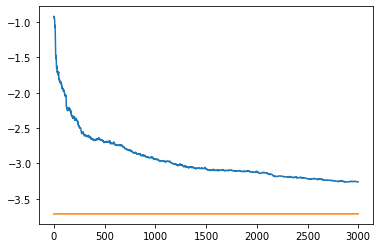

In [449]:
import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(out))]

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

### End of construction

I did go ahead and fix the optimization function below so that it matchs the one above but it has not been tested.  

In [323]:
k=53
job_id = np.load("/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobA_"+str(k)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".npy")
job_info = backend.retrieve_job(job_id[0])
hold = np.load("/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/run_"+str(k)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".npy",allow_pickle=True)
            

In [324]:
#beta = 0.602
#beta = 0.201
#A = 100 #10
#a = 0.5  #0.05
#gamma = 0.101
#c = 0.4

#beta_a = beta
#A_a = A
#a_a = a
#gamma_a = gamma
#c_a = c

#tt = t

def SPSA_from_load(k_min,k_max,load,method = 'simple', group = False ,hold = False):
    #Initalization
    k = 0
    phi_k = load['phi']
    alpha_k = load['alpha']
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_min,k_max):
        #Update c and a
        a_k = a/((A + k + 1)**beta)
        c_k = c/((k + 1)**gamma)
        a_ak = a_a/((A_a + k + 1)**beta_a)
        c_ak = c_a/((k + 1)**gamma_a)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for q in range(len(Delta_k[b])):
                Delta_k[b][q] = 1 - 2*np.random.binomial(size=None, n=1, p=0.5)
        phi_k_A = phi_k + c_k*Delta_k
        phi_k_B = phi_k - c_k*Delta_k
        
        #Find Delta Alpha
        Delta_ak = np.array(alpha_k)
        for n in range(bL):
            Delta_ak[n] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        alpha_k_A = alpha_k + c_ak*Delta_ak
        alpha_k_B = alpha_k - c_ak*Delta_ak
        norm_A = 1/np.sqrt(np.dot(alpha_k_A,alpha_k_A))
        norm_B = 1/np.sqrt(np.dot(alpha_k_B,alpha_k_B))
        alpha_k_A = norm_A*alpha_k_A
        alpha_k_B = norm_B*alpha_k_B
           
        #Find E    
        if group:
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/job_"+str(k)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs,meas,coefs,lengths = collect_energy_circs(alpha_k_A,phi_k_A,blocks,alpha_k_B,phi_k_B,blocks,alpha_k,phi_k,blocks)
            r = get_results(circs, method = method,save_id_file = save_id_file)
            E_Ap, E_Bp, E_fp = three_energies_from_results(r,meas,coefs,lengths)
        else:
            #A
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobA_"+str(k)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs_A, meas_A, coefs_A, pauli_A = collect_circs(alpha_k_A,phi_k_A,blocks)
            r_A = get_results(circs_A, method = method,save_id_file = save_id_file)
            E_A = energy_from_results(r_A,meas_A,coefs_A)
            #B
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobB_"+str(k)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs_B, meas_B, coefs_B, pauli_B = collect_circs(alpha_k_B,phi_k_B,blocks)
            r_B = get_results(circs_B, method = method,save_id_file = save_id_file)
            E_B = energy_from_results(r_B,meas_B,coefs_B)
            #f
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobf_"+str(k)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs_f, meas_f, coefs_f, pauli_f = collect_circs(alpha_k,phi_k,blocks)
            r_f = get_results(circs_f, method = method,save_id_file = save_id_file)
            E_f = energy_from_results(r_f,meas_f,coefs_f)

        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        
        #Update phi
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Update alpha
        g_ak = g * Delta_ak
        alpha_k = alpha_k - a_ak * g_ak
        norm = 1/np.sqrt(np.dot(alpha_k,alpha_k))
        alpha_k = norm*alpha_k

        
        #Print and save E
        print(k,E_f)
        #print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k,'c_a':c_ak,'a_a':a_ak,'alpha':alpha_k,'Delta_a':Delta_ak}
            np.save("/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/run_"+str(k)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u),[hold_k])
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [325]:
total = out

In [326]:
out = SPSA_from_load(54,200,hold[0],method = 'quantum_scaled',hold = True)
#out = SPSA_from_load(1999,3000,total[1999],method = 'matrix',hold = True)

62192af3976d9f4fce20c0a5
621946068c4ac85231687f9a
621949f68c4ac8915e687fb3
54 0.09364131490559141
62194df2a164870932e6ee4f
62195234c799db6369efbff6
6219563aa1648751ace6ee82
55 0.10956910584284801
62195810a16487e0bbe6ee87
621994c78c4ac8624a6881c4
621998d547f373a72a3783be
56 0.07711592145235213
62199cfa47f373a0573783de
6219a1595ac21f5d09473578
6219a5698c4ac8d598688228
57 0.006402569612386444
6219a95da1648713dde6f07c
6219adb25ac21fbfe94735ac
6219be46a164873681e6f12d
58 0.24058832600109428
6219cc3dc799db13a3efc310
6219d3648c4ac84a89688325
6219dca4a2eeaacffaad2e65
59 0.21128655661040188
6219e0a9c799db83d7efc35c
6219e4bca164875adee6f18d
6219f9833895be36ba3e275b
60 0.1582656097459152
6219fd928c4ac87f196883a1
621a022f8c4ac872906883ac
621a061fa164870b87e6f1d2
61 0.11572534586342842
621a0a12a2eeaa17aead2ecf
621a0e5f8c4ac8a5806883da
621a42f647f373d72a378642
62 0.4645026775137332
621a46e6976d9f42c820c599
621a4aecc799dbfeeeefc475
621a4f7f3895be80d93e284d
63 0.2513647975965187
621a53985ac21f2f194737

IBMQJobInvalidStateError: 'Unable to retrieve result for job 621f6965311615959fb9973a. Job was cancelled.'

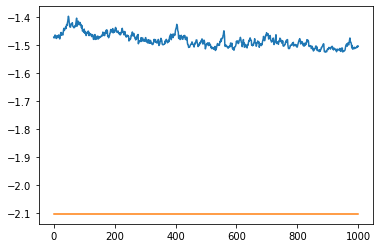

In [208]:
e,y = np.linalg.eig(H_complete)

import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(out))]

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

In [209]:
#total = total+out

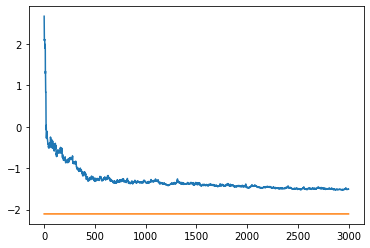

In [210]:
e,y = np.linalg.eig(H_complete)

import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(total))]

El = [total[i]['E'] for i in range(len(total))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

In [327]:
import numpy as np
El = []
kl = []
out = []
for k in range(0,130):
    job_id = np.load("/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobA_"+str(k)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".npy")
    job_info = backend.retrieve_job(job_id[0])
    hold = np.load("/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/run_"+str(k)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".npy",allow_pickle=True)
    out.append(hold[0])
    El.append(hold[0]['E'])
    kl.append(k)

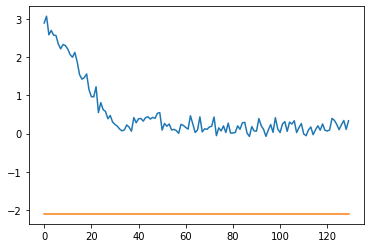

In [328]:
e,y = np.linalg.eig(H_complete)

import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(El))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

In [ ]:
out = El

# Save Data

In [450]:
import pickle
T=0
fpath = '/Users/stenger/Documents/Research/Hubbard_symmetries/VQE_CRy_Ansatz/Data/'

file_to_store = open(fpath + "VQE_matrix_new_T_"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".pickle", "wb")

pickle.dump(out, file_to_store)

In [451]:
#A = 20 #10
#a = 0.1  #0.05

import pickle
fpath = '/Users/stenger/Documents/Research/Hubbard_symmetries/VQE_CRY_Ansatz/Data/'

file_to_read = open(fpath + "VQE_matrix_new_T_"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".pickle", "rb")

loaded_object = pickle.load(file_to_read)

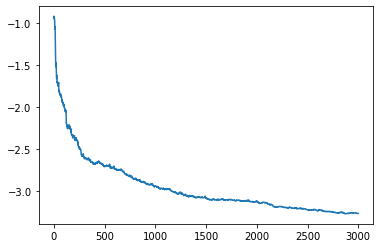

In [452]:
import matplotlib.pyplot as plt

El = [loaded_object[i]['E'] for i in range(len(loaded_object))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)